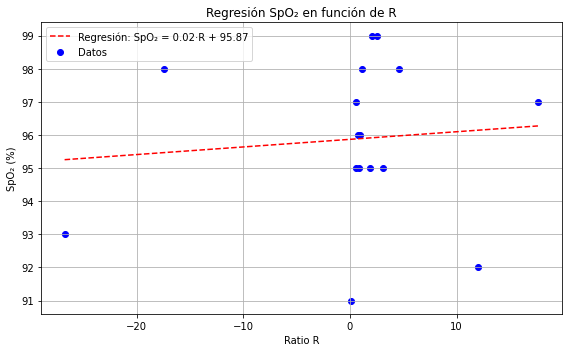

LUT[0] = (R=-26.74, SpO₂=93)
LUT[1] = (R=-17.405, SpO₂=98)
LUT[2] = (R=0.112, SpO₂=91)
LUT[3] = (R=0.567, SpO₂=95)
LUT[4] = (R=0.61, SpO₂=97)
LUT[5] = (R=0.748, SpO₂=96)
LUT[6] = (R=0.829, SpO₂=95)
LUT[7] = (R=0.923, SpO₂=96)
LUT[8] = (R=1.18, SpO₂=98)
LUT[9] = (R=1.878, SpO₂=95)
LUT[10] = (R=2.091, SpO₂=99)
LUT[11] = (R=2.568, SpO₂=99)
LUT[12] = (R=3.062, SpO₂=95)
LUT[13] = (R=4.592, SpO₂=98)
LUT[14] = (R=11.982, SpO₂=92)
LUT[15] = (R=17.631, SpO₂=97)


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta local a tus archivos
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Función para calcular AC/DC
def compute_ac_dc(signal):
    ac = np.std(signal)
    dc = np.mean(signal)
    return ac / dc if dc != 0 else np.nan

# Cargar archivos y procesar
ratios = []
spo2_values = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        match = re.search(r"raw_data_(\d+)_\d+", filename)
        if match:
            spo2 = int(match.group(1))
            path = os.path.join(folder_path, filename)
            df = pd.read_csv(path)
            
            if "RED_net" not in df.columns or "IR_net" not in df.columns:
                continue  # saltar si faltan columnas necesarias

            ac_red_dc_red = compute_ac_dc(df["RED_net"])
            ac_ir_dc_ir = compute_ac_dc(df["IR_net"])

            if not np.isnan(ac_red_dc_red) and not np.isnan(ac_ir_dc_ir) and ac_ir_dc_ir != 0:
                R = ac_red_dc_red / ac_ir_dc_ir
                ratios.append(R)
                spo2_values.append(spo2)

# Crear DataFrame de la LUT
lut_df = pd.DataFrame({"R": ratios, "SpO2": spo2_values}).sort_values("R")

# Graficar
plt.figure(figsize=(8, 5))
plt.scatter(lut_df["R"], lut_df["SpO2"], color="blue", label="Datos")
z = np.polyfit(lut_df["R"], lut_df["SpO2"], 1)
p = np.poly1d(z)
plt.plot(lut_df["R"], p(lut_df["R"]), "r--", label=f"Regresión: SpO₂ = {z[0]:.2f}·R + {z[1]:.2f}")
plt.xlabel("Ratio R")
plt.ylabel("SpO₂ (%)")
plt.title("Regresión SpO₂ en función de R")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar LUT como array
lut_array = list(zip(np.round(lut_df["R"], 3), lut_df["SpO2"]))
for i, (r, s) in enumerate(lut_array):
    print(f"LUT[{i}] = (R={r}, SpO₂={s})")


In [4]:
# Paso 1: calcular descenso medio por unidad de R
lut_ordenada = lut_df.sort_values("R")
deltas_spo2 = lut_ordenada["SpO2"].diff().dropna()
deltas_r = lut_ordenada["R"].diff().dropna()
pendientes = deltas_spo2 / deltas_r
pendiente_media = pendientes.mean()

# Paso 2: generar nueva LUT desde R = 0 hasta R = 5 (por ejemplo)
r_max = lut_ordenada["R"].max()
spo2_max = lut_ordenada.loc[lut_ordenada["R"].idxmax(), "SpO2"]

r_range = np.arange(0, 5.1, 0.1)
spo2_estimadas = spo2_max - pendiente_media * (r_max - r_range)

lut_extrapolada = pd.DataFrame({"R": r_range, "SpO2_estimada": spo2_estimadas})
lut_extrapolada

,R,SpO2_estimada
0,0.0,23.435946
1,0.1,23.853199
2,0.2,24.270451
3,0.3,24.687704
4,0.4,25.104957
5,0.5,25.522210
6,0.6,25.939462
7,0.7,26.356715
8,0.8,26.773968
9,0.9,27.191221


In [2]:
def lookup_spo2(r_value, lut_reference):
    # Buscar el índice donde R en la LUT es más cercano al R dado
    index = (np.abs(lut_reference["R"] - r_value)).idxmin()
    return lut_reference.loc[index, "SpO2"]

# Aplicar búsqueda sobre todos los archivos
lut_df["SpO2_estimada_LUT"] = lut_df["R"].apply(lambda r: lookup_spo2(r, lut_df))

# Mostrar comparación
for i, row in lut_df.iterrows():
    print(f"[LUT] Archivo con R = {row['R']:.2f} -> SpO₂ estimada: {row['SpO2_estimada_LUT']} | Real: {row['SpO2']}")


[LUT] Archivo con R = -26.74 -> SpO₂ estimada: 93.0 | Real: 93.0
[LUT] Archivo con R = -17.40 -> SpO₂ estimada: 98.0 | Real: 98.0
[LUT] Archivo con R = 0.11 -> SpO₂ estimada: 91.0 | Real: 91.0
[LUT] Archivo con R = 0.57 -> SpO₂ estimada: 95.0 | Real: 95.0
[LUT] Archivo con R = 0.61 -> SpO₂ estimada: 97.0 | Real: 97.0
[LUT] Archivo con R = 0.75 -> SpO₂ estimada: 96.0 | Real: 96.0
[LUT] Archivo con R = 0.83 -> SpO₂ estimada: 95.0 | Real: 95.0
[LUT] Archivo con R = 0.92 -> SpO₂ estimada: 96.0 | Real: 96.0
[LUT] Archivo con R = 1.18 -> SpO₂ estimada: 98.0 | Real: 98.0
[LUT] Archivo con R = 1.88 -> SpO₂ estimada: 95.0 | Real: 95.0
[LUT] Archivo con R = 2.09 -> SpO₂ estimada: 99.0 | Real: 99.0
[LUT] Archivo con R = 2.57 -> SpO₂ estimada: 99.0 | Real: 99.0
[LUT] Archivo con R = 3.06 -> SpO₂ estimada: 95.0 | Real: 95.0
[LUT] Archivo con R = 4.59 -> SpO₂ estimada: 98.0 | Real: 98.0
[LUT] Archivo con R = 11.98 -> SpO₂ estimada: 92.0 | Real: 92.0
[LUT] Archivo con R = 17.63 -> SpO₂ estimada: 97.0